In [1]:
# Does multi-profile deconvolution (Sharp and Birchall 2010, PASA, sec. 5.2)

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import astropy
from astropy.io import fits
import copy

%matplotlib inline

In [2]:
# gaussian profile
def gaus1d(x_pass, mu_pass, sigma_pass):
    
    return (1./(sigma_pass*np.sqrt(2.*np.pi))) * np.exp(-0.5 * np.power((x_pass-mu_pass)/sigma_pass,2.) )

In [3]:
# Yoo-Jung's spectrum (not the broadband one)

hdul = fits.open('./data/stacked.fits')
test_data = hdul[0].data[0,:,:] # all 3 spectra
array_variance = hdul[0].data[1,:,:]

# ersatz bad pixel mask
y_center_1 = 104
y_center_2 = 160
y_center_3 = 179

# just 1 spectrum
test_data_1 = np.copy(test_data)
test_data_1[0:y_center_1-4,:] = 0
test_data_1[y_center_1+4:,:] = 0

# spectra 1 and 2
test_data_12 = np.copy(test_data)
test_data_12[0:y_center_1-4,:] = 0
test_data_12[y_center_1+4:y_center_2-4,:] = 0
test_data_12[y_center_2+4:,:] = 0

# spectra 1, 2, 3
test_data_123 = np.copy(test_data)
test_data_123[0:y_center_1-4,:] = 0
test_data_123[y_center_1+4:y_center_2-4,:] = 0
test_data_123[y_center_2+4:y_center_3-4,:] = 0
test_data_123[y_center_3+4:,:] = 0

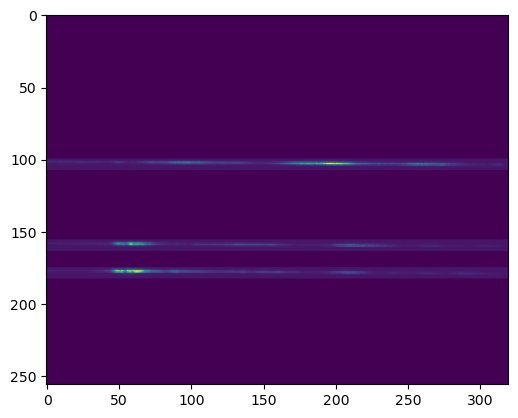

In [14]:
plt.imshow(test_data_123)
plt.show()

In [15]:
# fit an extended Gaussian to the broadband image

#array_broadband = test_data[0,:,:]





# normalize ## ## necessary?
#test_data_1 = np.divide(test_data_1,np.nanmax(test_data_1))


In [4]:
# make the enclosing profile of the spectrum

def simple_profile(y_center, sigma_pass=1):
    # make simple 1D Gaussian profile in x-direction

    array_profile = np.zeros(np.shape(test_data))
    xgrid, ygrid = np.meshgrid(np.arange(0,np.shape(array_profile)[1]),np.arange(0,np.shape(array_profile)[0]))
    array_profile = gaus1d(x_pass = ygrid, mu_pass = y_center, sigma_pass=sigma_pass)

    # normalize it such that the marginalization in x (in (x,lambda) space) is 1
    # (with a perfect Gaussian profile in x this is redundant)
    array_profile = np.divide(array_profile,np.sum(array_profile, axis=0))
    
    return array_profile

In [5]:
# make profiles for all 3 spectra

simple_profile_1 = simple_profile(y_center=y_center_1,sigma_pass=3)
simple_profile_2 = simple_profile(y_center=y_center_2,sigma_pass=3)
simple_profile_3 = simple_profile(y_center=y_center_3,sigma_pass=3)

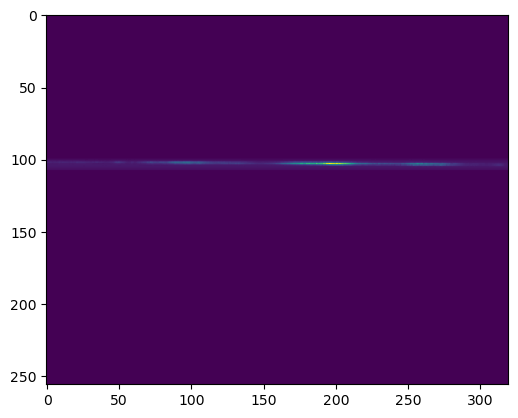

In [24]:
plt.imshow(np.multiply(D,simple_profile_1))
plt.show()

In [6]:
# 1 spectrum only

# define test data
D = test_data_1

# extent of detector in x-dir
x_extent = np.shape(simple_profile_1)[1]

# initialize array to hold flux
eta_all_cols = np.zeros(x_extent)

# loop over cols
for col in range(0,x_extent): 
    
    # initialize
    c_11 = 0
    b_1 = 0
    
    # loop over pixels
    for i in range(100,101):
    
        c_11 += simple_profile_1[i,col] * simple_profile_1[i,col] / array_variance[i,col]
        
        b_1 += D[i,col] * simple_profile_1[i,col] / array_variance[i,col]
        
        #test_data
    
        #Di = test_data # CCD data value at pixel i
        
    # integrated intensity of fiber 1 at the current wavelength element
    eta_1 = b_1/c_11
    
    eta_all_cols[col] = eta_1

In [7]:
# 2 spectra

# define test data
D = test_data_12

# extent of detector in x-dir
x_extent = np.shape(simple_profile_1)[1]
y_extent = np.shape(simple_profile_1)[0]

# initialize dict to hold flux for each spectrum
eta = {'1':np.zeros(x_extent),'2':np.zeros(x_extent)}

# loop over cols
for col in range(0,x_extent): 
    
    # initialize
    c_11 = 0
    c_12 = 0
    c_22 = 0
    b_1 = 0
    b_2 = 0
    
    # loop over pixels
    for i in range(0,y_extent):
    
        c_11 += simple_profile_1[i,col] * simple_profile_1[i,col] / array_variance[i,col]
        
        c_12 += simple_profile_1[i,col] * simple_profile_2[i,col] / array_variance[i,col]
        
        c_22 += simple_profile_2[i,col] * simple_profile_2[i,col] / array_variance[i,col]
        
        b_1 += D[i,col] * simple_profile_1[i,col] / array_variance[i,col]
        
        b_2 += D[i,col] * simple_profile_2[i,col] / array_variance[i,col]
        
    # by symmetry
    c_21 = np.copy(c_12)
    
    # assemble matrices
    b_mat = np.array([b_1, b_2])
    c_mat = np.array([[c_11, c_12],[c_21, c_22]])
    
    eta_mat = b_mat @ np.linalg.pinv(c_mat)
        
    # integrated intensity of fibers at the current wavelength element
    '''
    spec_lw, istop, itn, normr, normar, norma, conda, normx = \
               lsmr(c_mat, b_mat)
    
    eta_1 = b_1/c_11
    '''
    #eta_all_cols[col] = eta_1
    
    eta['1'][col] = eta_mat[0]
    eta['2'][col] = eta_mat[1]
    
    #print(eta_mat)

/var/folders/8y/ztvmc5ys1pn64bjywt1qp4k40000gs/T/ipykernel_4704/1208343981.py:26: RuntimeWarning: invalid value encountered in double_scalars
  c_11 += simple_profile_1[i,col] * simple_profile_1[i,col] / array_variance[i,col]
/var/folders/8y/ztvmc5ys1pn64bjywt1qp4k40000gs/T/ipykernel_4704/1208343981.py:28: RuntimeWarning: invalid value encountered in double_scalars
  c_12 += simple_profile_1[i,col] * simple_profile_2[i,col] / array_variance[i,col]
/var/folders/8y/ztvmc5ys1pn64bjywt1qp4k40000gs/T/ipykernel_4704/1208343981.py:30: RuntimeWarning: invalid value encountered in double_scalars
  c_22 += simple_profile_2[i,col] * simple_profile_2[i,col] / array_variance[i,col]
/var/folders/8y/ztvmc5ys1pn64bjywt1qp4k40000gs/T/ipykernel_4704/1208343981.py:32: RuntimeWarning: invalid value encountered in double_scalars
  b_1 += D[i,col] * simple_profile_1[i,col] / array_variance[i,col]
/var/folders/8y/ztvmc5ys1pn64bjywt1qp4k40000gs/T/ipykernel_4704/1208343981.py:34: RuntimeWarning: invalid value 

In [14]:
# 3 spectra

# define test data
D = test_data_123

# extent of detector in x-dir
x_extent = np.shape(simple_profile_1)[1]
y_extent = np.shape(simple_profile_1)[0]

# initialize dict to hold flux for each spectrum
eta = {'1':np.zeros(x_extent),'2':np.zeros(x_extent),'3':np.zeros(x_extent)}

# loop over cols
for col in range(0,x_extent): 
    
    # initialize
    c_11 = 0
    c_12 = 0
    c_13 = 0
    c_22 = 0
    c_23 = 0
    c_33 = 0
    b_1 = 0
    b_2 = 0
    b_3 = 0
    
    # loop over pixels
    for i in range(0,y_extent):
    
        c_11 += simple_profile_1[i,col] * simple_profile_1[i,col] / array_variance[i,col]
        
        c_12 += simple_profile_1[i,col] * simple_profile_2[i,col] / array_variance[i,col]
        
        c_13 += simple_profile_1[i,col] * simple_profile_3[i,col] / array_variance[i,col]
        
        c_22 += simple_profile_2[i,col] * simple_profile_2[i,col] / array_variance[i,col]
        
        c_23 += simple_profile_2[i,col] * simple_profile_3[i,col] / array_variance[i,col]
        
        c_33 += simple_profile_3[i,col] * simple_profile_3[i,col] / array_variance[i,col]
        
        b_1 += D[i,col] * simple_profile_1[i,col] / array_variance[i,col]
        
        b_2 += D[i,col] * simple_profile_2[i,col] / array_variance[i,col]
        
        b_3 += D[i,col] * simple_profile_3[i,col] / array_variance[i,col]
        
    # by symmetry
    c_21 = np.copy(c_12)
    c_31 = np.copy(c_13)
    c_32 = np.copy(c_23)
    
    # set off-diagonal vals to zero to make sparse
    c_21 = 0
    c_12 = 0
    c_13 = 0
    c_31 = 0
    c_23 = 0
    c_32 = 0
    
    # assemble matrices
    b_mat = np.array([b_1, b_2, b_3])
    c_mat = np.array([[c_11, c_12, c_13],[c_21, c_22, c_23],[c_31, c_32, c_33]])
    
    print(b_mat)
    
    print(c_mat)
    eta_mat = b_mat @ np.linalg.pinv(c_mat)
        
    # integrated intensity of fibers at the current wavelength element
    '''
    spec_lw, istop, itn, normr, normar, norma, conda, normx = \
               lsmr(c_mat, b_mat)
    
    eta_1 = b_1/c_11
    Ax = b
    '''
    #eta_all_cols[col] = eta_1
    
    eta['1'][col] = eta_mat[0]
    eta['2'][col] = eta_mat[1]
    eta['3'][col] = eta_mat[2]
    
    #print(eta_mat)

[17.55172777 15.77351332 16.98011264]
[[0.00168981 0.         0.        ]
 [0.         0.00166931 0.        ]
 [0.         0.         0.00167625]]
[12.05236574 11.07080225 11.75934967]
[[0.00117866 0.         0.        ]
 [0.         0.00117491 0.        ]
 [0.         0.         0.00119059]]
[nan nan nan]
[[nan  0.  0.]
 [ 0. nan  0.]
 [ 0.  0. nan]]
[nan nan nan]
[[nan  0.  0.]
 [ 0. nan  0.]
 [ 0.  0. nan]]
[38.37547488 34.17825073 37.97475663]
[[0.00402615 0.         0.        ]
 [0.         0.00374114 0.        ]
 [0.         0.         0.00399758]]
[13.94297281 11.76326574 12.07122106]
[[0.00133702 0.         0.        ]
 [0.         0.00129215 0.        ]
 [0.         0.         0.00122802]]
[15.49380656 16.40702314 16.97935676]
[[0.00156306 0.         0.        ]
 [0.         0.00179463 0.        ]
 [0.         0.         0.00175723]]
[20.42403536 17.61422923 19.43662624]
[[0.00206129 0.         0.        ]
 [0.         0.00191092 0.        ]
 [0.         0.         0.00206876]

/var/folders/8y/ztvmc5ys1pn64bjywt1qp4k40000gs/T/ipykernel_4704/3796582689.py:30: RuntimeWarning: invalid value encountered in double_scalars
  c_11 += simple_profile_1[i,col] * simple_profile_1[i,col] / array_variance[i,col]
/var/folders/8y/ztvmc5ys1pn64bjywt1qp4k40000gs/T/ipykernel_4704/3796582689.py:32: RuntimeWarning: invalid value encountered in double_scalars
  c_12 += simple_profile_1[i,col] * simple_profile_2[i,col] / array_variance[i,col]
/var/folders/8y/ztvmc5ys1pn64bjywt1qp4k40000gs/T/ipykernel_4704/3796582689.py:34: RuntimeWarning: invalid value encountered in double_scalars
  c_13 += simple_profile_1[i,col] * simple_profile_3[i,col] / array_variance[i,col]
/var/folders/8y/ztvmc5ys1pn64bjywt1qp4k40000gs/T/ipykernel_4704/3796582689.py:36: RuntimeWarning: invalid value encountered in double_scalars
  c_22 += simple_profile_2[i,col] * simple_profile_2[i,col] / array_variance[i,col]
/var/folders/8y/ztvmc5ys1pn64bjywt1qp4k40000gs/T/ipykernel_4704/3796582689.py:38: RuntimeWarning

In [15]:
eta['1']

array([10386.82789503, 10225.52145461,            nan,            nan,
        9531.56198306, 10428.36017797,  9912.47914705,  9908.38443277,
        9788.37209806, 10609.9223971 ,            nan,            nan,
       10586.6478111 ,  9965.77726372, 10248.51021958, 10228.9361859 ,
        9606.81508781,  9749.4057738 , 10563.39578815, 10400.33109578,
        9778.47323539, 10242.62775948, 10033.2594286 , 10037.48414862,
        9689.6040442 ,  9772.66039783, 10518.64694035, 10115.04049348,
        9585.3217294 ,  9915.34931035,  9546.82749379, 10174.62616694,
        9759.44045238,  9338.84679793,  9331.5806283 ,  9316.747751  ,
        9250.73968104,  9812.45229566,  9505.63080089,  9346.82492214,
        9100.56414657,  9394.8053036 ,  9334.93243847,  9199.67126657,
        9562.44878723,  9293.3595071 ,  9653.01200369, 10236.20721009,
        9454.05833005,  9227.01612166, 10623.15000707, 11165.97284438,
        9195.7560225 ,  9165.48825912,  9508.80504014,  9073.06345252,
      

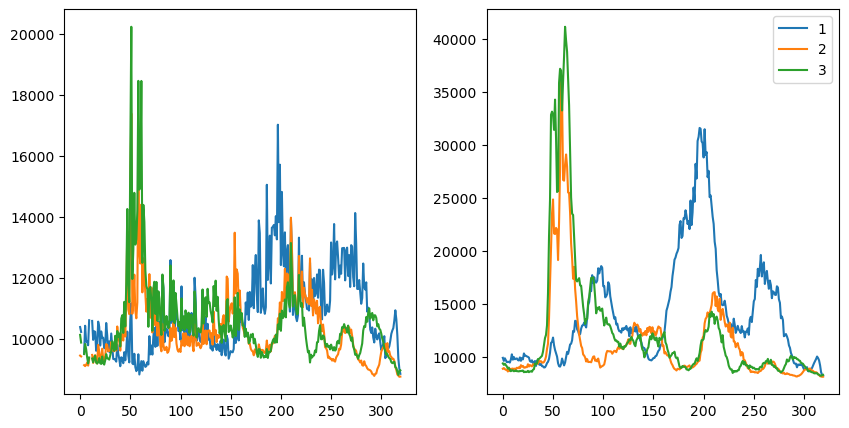

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(eta['1'], label='1')
axs[0].plot(eta['2'], label='2')
axs[0].plot(eta['3'], label='3')

axs[1].plot(np.sum(test_data_1[99:99+t,:],axis=0), label='1')
axs[1].plot(np.sum(test_data_12[155:155+t,:],axis=0), label='2')
axs[1].plot(np.sum(test_data_123[175:175+t,:],axis=0), label='3')
#plt.plot(eta_all_cols, label='1 spec only')
plt.legend()
plt.show()